In [1]:
import torch
import torch.nn as nn
from exp.nb_12 import test_close
torch.seed()

2780109999982521504

In [26]:
rnn = nn.LSTM(10, 20, 1, batch_first=True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
output.shape, hn.shape, cn.shape

(torch.Size([3, 5, 20]), torch.Size([1, 3, 20]), torch.Size([1, 3, 20]))

In [3]:
# every thing look find now. We will replace our implement by torch.nn.RNN

In [4]:
from fastai.data.external import URLs, untar_data

In [5]:
import fastai

In [6]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

(#2) [Path('/home/vule/.fastai/data/human_numbers/train.txt'),Path('/home/vule/.fastai/data/human_numbers/valid.txt')]

In [7]:
from fastcore.foundation import L
import pandas as pd
from torch import tensor
from fastai.data.core import DataLoaders

# Load data
train_df = pd.read_csv(path/'train.txt', header=None, names=['number'])
valid_df = pd.read_csv(path/'valid.txt', header=None, names=['number'])
data_df = pd.concat([train_df, valid_df])
data_df.number = data_df.number.apply(lambda x: x.strip())


# Convert word to number.
text = ' . '.join(data_df.number.to_list())
tokens = text.split(' ')
vocabs = L(tokens).unique()
word2idx = {w:i for i, w in enumerate(vocabs)}
nums = [word2idx[w] for w in tokens]

In [8]:
len(vocabs)

30

In [9]:
# L([(tokens[i:i+3], tokens[i+3]) for i in range(0, len(tokens)-4, 3)])
seqs = L([(tensor(nums[i:i+3]), nums[i+3]) for i in range(0, len(nums)-4, 3)])

bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)

In [10]:
dls.train_ds; dls.valid_ds

(#4207) [(tensor([ 1,  8, 29]), 26),(tensor([26,  5,  1]), 8),(tensor([ 8, 29, 26]), 6),(tensor([6, 1, 8]), 29),(tensor([29, 26,  7]), 1),(tensor([ 1,  8, 29]), 26),(tensor([26,  8,  1]), 8),(tensor([ 8, 29, 26]), 9),(tensor([9, 1, 8]), 29),(tensor([29, 27,  1]), 8)...]

In [11]:
b = dls.one_batch()
b[0].shape, b[1].shape

(torch.Size([64, 3]), torch.Size([64]))

In [12]:
from fastai.learner import Learner
from fastai.callback.all import *
from torch.functional import F
from fastai.metrics import accuracy

In [13]:
# creating more signal:
ls = 16
seqs = L([(tensor(nums[i:i+ls]), tensor(nums[i+1:i+1+ls])) for i in range(0, len(nums)-ls-1, ls)])
cut = int(len(seqs) * 0.80)
bs = 64
m = len(seqs) // 64
# reorder seqs to reuse the last state
print(seqs[0], seqs[m-1])
print(seqs[m], seqs[2*m-1])

def group_chucks(ds, bs):
    m = len(ds) // bs
    reorder_seqs = L()
    for m_i in range(m): reorder_seqs += [seqs[bs_i*m + m_i] for bs_i in range(bs)]
    return reorder_seqs

dls = DataLoaders.from_dsets(group_chucks(seqs[:cut], bs), group_chucks(seqs[cut:], bs), bs=bs, shuffle=False, drop_last=True)
X, y = dls.one_batch()

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]), tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])) (tensor([ 8,  1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1]), tensor([ 1,  2, 28, 22,  9,  1,  2, 28, 23,  1,  2, 28, 23,  0,  1,  2]))
(tensor([ 2, 28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2]), tensor([28, 23,  2,  1,  2, 28, 23,  3,  1,  2, 28, 23,  4,  1,  2, 28])) (tensor([ 5,  1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8]), tensor([ 1,  4, 28, 23,  6,  1,  4, 28, 23,  7,  1,  4, 28, 23,  8,  1]))


In [44]:
from torch.autograd import Variable
from torch.nn import Module
from torch.functional import F


class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel5, self).__init__()
        self.n_hidden = n_hidden
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.rnn = torch.nn.LSTM(n_hidden, n_hidden, 1, batch_first=True)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1, 64, n_hidden)
        self.c = torch.zeros(1, 64, n_hidden)
    def forward(self, x):
        h, c = self.h, self.c
        input = self.i_h(x)
        outs, (h, c) = self.rnn(input, (h, c))
        self.h = h.detach()
        self.c = c.detach()
        return self.h_o(outs)
    
    def reset(self):
        self.h = torch.zeros(1, 64, self.n_hidden)
        self.c = torch.zeros(1, 64, self.n_hidden)


model5 = LMModel5(vocab_sz=len(vocabs), n_hidden=64)
model5.reset()
o4 = model5(X); print(o4.shape)

torch.Size([64, 16, 30])


In [45]:
X.shape

torch.Size([64, 16])

In [46]:
def loss_function(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocabs)), targ.view(-1))

learn = Learner(dls, model5, loss_func=loss_function, metrics=accuracy, cbs=[ModelResetter])

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.02290867641568184)

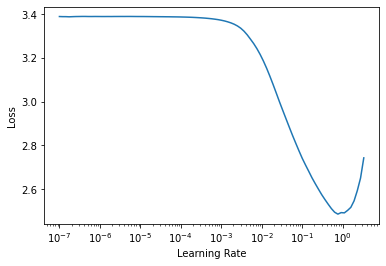

In [47]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.263033,3.099261,0.321777,00:00
1,2.559287,1.927389,0.370524,00:00
2,1.871091,1.606510,0.473551,00:00
3,1.532904,1.356704,0.591309,00:00
4,1.293692,1.207724,0.615397,00:00
5,1.114882,1.034506,0.666667,00:00
6,0.959610,0.926340,0.717936,00:00
7,0.830869,0.820070,0.756673,00:00
8,0.720199,0.735791,0.775635,00:00
9,0.632438,0.671127,0.801921,00:00


In [50]:
# stack RNN
from torch.autograd import Variable
from torch.nn import Module
from torch.functional import F


class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden):
        super(LMModel6, self).__init__()
        self.n_hidden = n_hidden
        self.i_h = torch.nn.Embedding(vocab_sz, n_hidden)
        self.rnn = torch.nn.LSTM(n_hidden, n_hidden, 2, batch_first=True)
        self.h_o = torch.nn.Linear(n_hidden, vocab_sz)

    def forward(self, x):
        h, c = self.h, self.c
        input = self.i_h(x)
        outs, (h, c) = self.rnn(input, (h, c))
        self.h = h.detach()
        self.c = c.detach()
        return self.h_o(outs)
    
    def reset(self):
        self.h = torch.zeros(2, 64, self.n_hidden)
        self.c = torch.zeros(2, 64, self.n_hidden)



model6 = LMModel6(vocab_sz=len(vocabs), n_hidden=64)
model6.reset()
o6 = model6(X); print(o6.shape)

torch.Size([64, 16, 30])


In [51]:
learn = Learner(dls, model6, loss_func=loss_function, metrics=accuracy, cbs=[ModelResetter])

In [53]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.395912,0.522062,0.846191,00:00
1,0.381728,0.506861,0.834880,00:01
2,0.342798,0.463079,0.863770,00:00
3,0.299310,0.372765,0.890544,00:00
4,0.226903,0.267300,0.937988,00:01
5,0.180516,0.229288,0.947754,00:00
6,0.127556,0.178088,0.959961,00:01
7,0.086142,0.157217,0.963786,00:01
8,0.060773,0.132739,0.970947,00:01
9,0.045794,0.121799,0.969645,00:01
